In [1]:
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../src")))

from src.data_modules.detection_data_module import (
    CbisDdsmDataModuleDetection as DetectionDataModule,
)
from src.models.detection_model import DetectionModel

/home/tmb2k01/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
datamodule = DetectionDataModule(
    root_dir="../data/cbis-ddsm-detec", tumor_type="mass", batch_size=1, num_workers=4
)

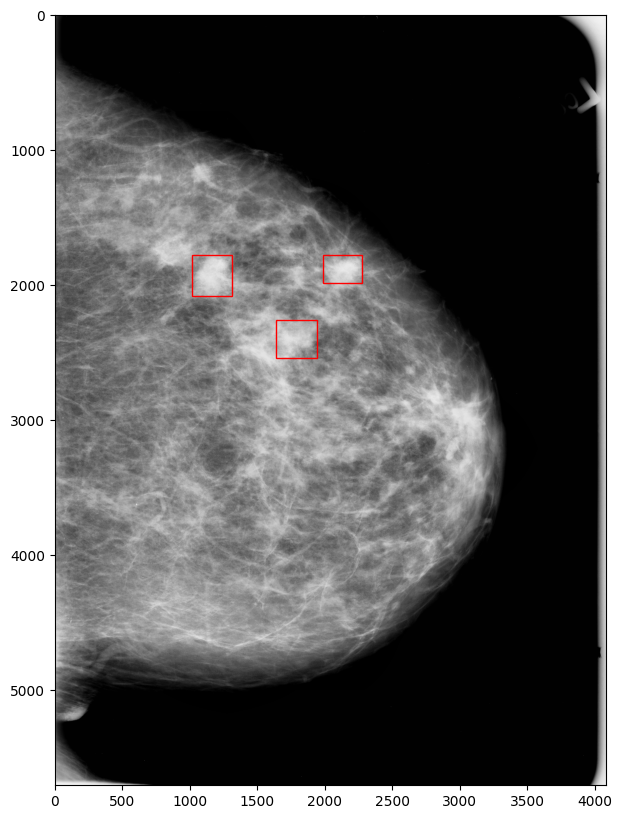

In [5]:
for batch in datamodule.train_dataloader():
    x, y = batch[0][0], batch[1][0]

    image = x.squeeze().numpy()

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image, cmap="gray")

    boxes = y["boxes"]
    for i in range(0, len(boxes)):
        xmin, ymin = boxes[i][0], boxes[i][1]
        xmax, ymax = boxes[i][2], boxes[i][3]

        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )

        ax.add_patch(rect)

    plt.show()
    break

In [7]:
model = DetectionModel(weight_path="../models/mass-detection.ckpt")

/home/tmb2k01/hamlab/src/models/detection_model.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight_path, map_location=self.device)


Loaded weights from ../models/mass-detection.ckpt


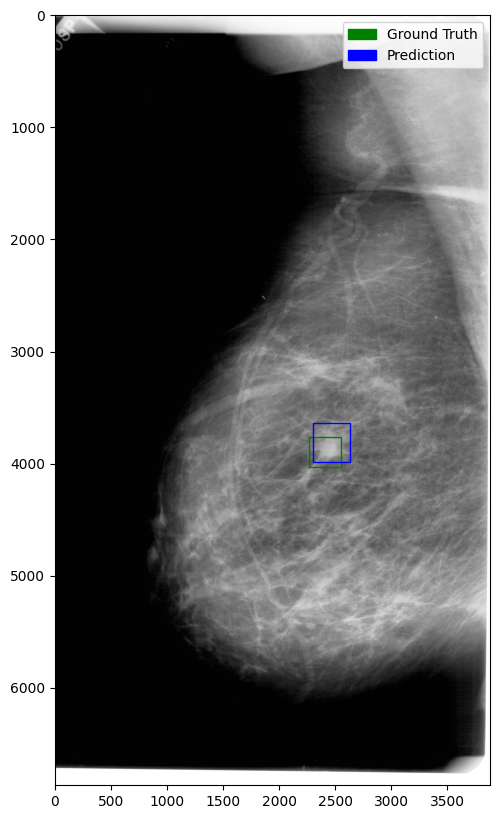

In [8]:
# Get a validation batch
for batch in datamodule.val_dataloader():
    x, y = batch[0][0], batch[1][0]

    # Prepare the image
    image = x.squeeze().numpy()

    # Get ground truth boxes
    ground_truth_boxes = y["boxes"]

    # Get model predictions
    model.eval()
    with torch.no_grad():
        predictions = model(x.unsqueeze(0))
    confidence_threshold = 0.3
    predicted_boxes = predictions[0]["boxes"][
        predictions[0]["scores"] > confidence_threshold
    ]

    # Plot the image
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image, cmap="gray")

    # Plot ground truth boxes in green
    for box in ground_truth_boxes:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=1,
            edgecolor="g",
            facecolor="none",
            label="Ground Truth",
        )
        ax.add_patch(rect)

    # Plot predicted boxes in blue
    for box in predicted_boxes:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=1,
            edgecolor="b",
            facecolor="none",
            label="Prediction",
        )
        ax.add_patch(rect)

    plt.legend(
        handles=[
            patches.Patch(color="green", label="Ground Truth"),
            patches.Patch(color="blue", label="Prediction"),
        ]
    )
    plt.show()
    break